# Set up environment

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow.keras.utils as utils

import os
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests

## Declare parameters

In [2]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

IMAGE_SIZE = 512

API_KEY = "4INghUtThsIBWPTIcvfKyf0kNS6MtSXcC4R6mpNB"
BASE_URL = "https://api.nal.usda.gov/fdc/v1/"

## Enable GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


# Input model

## Fetch class names

In [4]:
BURGER_FRIES_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "burger_fries")

class_names = ['background', 'burger', 'fries']

## Fetch model architecture

Currently only support resnet_50 backbone.

In [5]:
print("Fetching model architecture... ", end="")

# load pretrained model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

# replace classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(class_names))

# create mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# replace mask predictor
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, len(class_names))

model = model.to(device)

print("done")

Fetching model architecture... done


## Load model weights

In [7]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_segmentation", "resnet_50", "fine_tuning.pt")

print("Loading learnt model weights...", end="")
model.load_state_dict(torch.load(MODEL_PATH))
print("done")

Loading learnt model weights...done


# Predict on image

## Load image from url

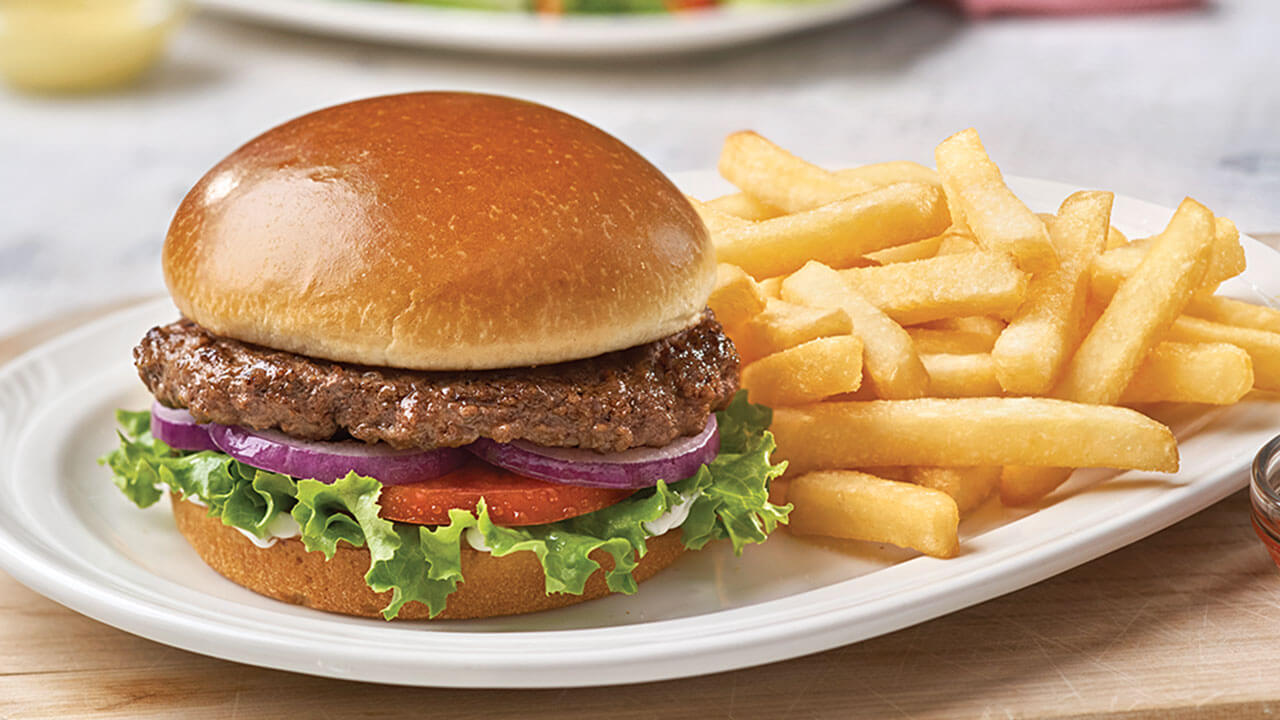

In [8]:
url = "https://d9hyo6bif16lx.cloudfront.net/live/img/production/detail/menu/lunch-dinner_999-combohs_all-american-burger-fries.jpg"

def loadImage(url):
    filename = url.split('/')[-1]
    img = utils.get_file(filename, url)
    img = Image.open(img)
    return img

img = loadImage(url)
img

## Format image for model input

In [9]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = torchvision.transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        return img

transform = CustomTransform(image_size=IMAGE_SIZE)

img = transform(img)
x = img.unsqueeze(0)

## Run inference on image

In [10]:
x = x.to(device)
model.eval()
    
with torch.no_grad():
    outputs = model(x)
    
outputs

[{'boxes': tensor([[2.3791e+02, 5.1786e+01, 5.1200e+02, 2.2368e+02],
          [5.8427e+01, 4.1106e+01, 3.1357e+02, 2.4485e+02],
          [2.0755e+01, 3.7984e+01, 5.1200e+02, 2.5073e+02],
          [0.0000e+00, 0.0000e+00, 4.9971e+02, 3.1154e+02],
          [2.9567e+00, 4.8097e+01, 3.1441e+02, 3.9532e+02],
          [3.7106e+02, 7.2445e+01, 5.1200e+02, 1.8581e+02],
          [5.0861e+01, 4.2393e+01, 3.1764e+02, 2.3019e+02],
          [0.0000e+00, 5.3907e+01, 5.1200e+02, 4.6168e+02],
          [1.7771e+02, 2.9927e+01, 4.8905e+02, 3.4302e+02],
          [2.0644e+02, 2.8418e+01, 5.1200e+02, 3.5725e+02],
          [2.6882e+02, 4.8104e+01, 4.3550e+02, 1.8053e+02],
          [0.0000e+00, 2.1096e-01, 7.7232e+01, 4.1698e+01],
          [4.4778e+02, 6.6728e+01, 5.1200e+02, 1.7965e+02]], device='cuda:0'),
  'labels': tensor([2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2], device='cuda:0'),
  'scores': tensor([0.9838, 0.9745, 0.6516, 0.4429, 0.2133, 0.1915, 0.1408, 0.1124, 0.1089,
          0.1089, 0.10

## Extract results from model output

In [38]:
CONFIDENCE_THRESHOLD = 0.7

def extractResults(output):
    boxes = []
    labels = []
    masks = []
    
    for i in range(len(output["labels"])):
        if(output["scores"][i] < CONFIDENCE_THRESHOLD):
            break
        
        # extract bounding box
        boxes.append(output["boxes"][i])
        
        # extract label
        labels.append(output["labels"][i])
        
        # extract segmentation mask
        masks.append(output["masks"][i])
                       
    return boxes, labels, masks

boxes, labels, masks = extractResults(outputs[0])

[tensor(2, device='cuda:0'), tensor(1, device='cuda:0')]


## Draw predicted bounding boxes on image

tensor(2, device='cuda:0')
tensor(1, device='cuda:0')


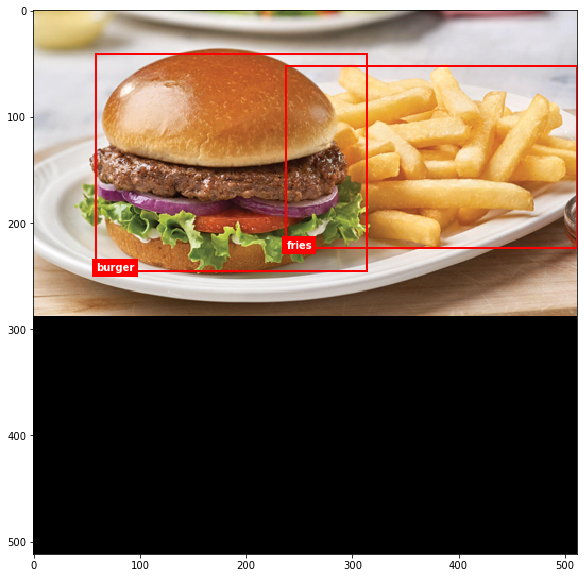

In [39]:
def drawBoxes(img):
    fig, axis= plt.subplots(1, figsize=(10,10))
    
    # unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    
    plt.imshow(img)

    # draw results
    for i in range(len(labels)):
        # draw bounding box
        x1, y1, x2, y2 = boxes[i]
        box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        axis.add_patch(box)
        axis.text(x1, y2, class_names[labels[i]], fontdict=dict(color='w', weight='bold'), bbox=dict(facecolor='r', edgecolor='none'))
        
    plt.show()

drawBoxes(img.clone())

# Weight estimation

The next step is to estimate the weights for each of the foods present.

## Calculate surface areas

The first stage to estimating the portion size is to calculate the surface area for each of the foods detected. In order to do so we assume a standard plate diameter of 25cm to gain an estiamte for cms per pixel. Then using the segmentation mask we can compute the visible surface areas.

In [35]:
PLATE_DIAMETER = 25 # cm

# estimate cms per pixel using standard plate diameter
cm_per_pixel = PLATE_DIAMETER / IMAGE_SIZE

surface_areas = []
for mask in masks:
    # calculate area in pixels
    area = (mask > 0).sum().item()
    
    # convert to cms
    area *= cm_per_pixel ** 2
    
    surface_areas.append(area)

## Estimate volumes and weights

The next step is to estimate the volume of the food by using its given depth from a database of averages. In practice, this depth could be infered from a depth map. We then use the food's density, provided by http://foodinfo.us/Densities to infer its weight.

In [68]:
food_data = {
    'burger': {
        'depth': 6,
        'density': 0.421
    },
    'fries': {
        'depth': 3,
        'density': 0.6 
    }
}


volumes = []
weights = []
foods = []

i = 0
for lbl in labels:  
    class_name = class_names[lbl]
    
    foods.append(class_name)
    
    depth = food_data[class_name]['depth']
    density = food_data[class_name]['density']
    
    # estimate volume using depth
    volumes.append(surface_areas[i] * depth)
    
    # estimate weight using density
    weights.append(volumes[i] * density)
    
    i += 1

## Show overlay of segmentation masks with estimated volumes and weights

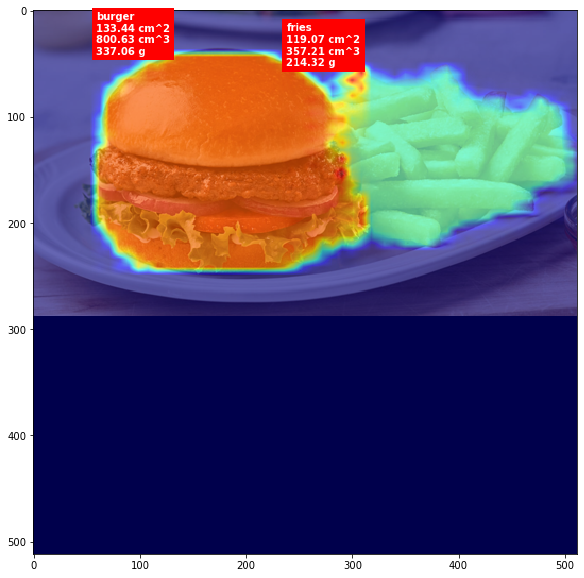

In [70]:
def drawMasks(img):
    fig, axis= plt.subplots(1, figsize=(10,10))
    
    # unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    
    plt.imshow(img)
    
    mask = torch.zeros(IMAGE_SIZE, IMAGE_SIZE)

    # draw results
    i = 0
    for food in foods:
        # add to overall mask
        mask += masks[i].cpu().numpy().squeeze() * (i+1)
        
        # fetch box so know where to place label
        x1, y1, x2, y2 = boxes[i]
        
        # draw size information label
        lbl = "{0}\n{1:.2f} cm^2\n{2:.2f} cm^3\n{3:.2f} g".format(food, surface_areas[i], volumes[i], weights[i])
        axis.text(x1, y1, lbl, fontdict=dict(color='w', weight='bold'), bbox=dict(facecolor='r', edgecolor='none'))
        
        i += 1
        
    plt.imshow(mask, cmap='jet', alpha=0.6)
        
    plt.show()

drawMasks(img.clone())

# Nutritional lookup

## Perform lookup of food items

Using the FoodData Central API we perform a lookup for each of the food items detected using the class as the search query.

In [71]:
food_ids = []

for class_name in foods:  
    # seach FoodData Central with class name as search term
    url = BASE_URL+"search"
    params = {
        'api_key': API_KEY,
        'generalSearchInput': class_name
    }
    data = requests.get(url=url, params=params).json()

    # take foodId from first result
    if len(data['foods']) > 0:
        food_ids.append(data['foods'][0]['fdcId'])
    else:
        print("Unable to find food with class {0}".format(class_name))
        
food_ids

[787667, 559487]

## Retrieve food information

We then request its nutritional contents and typical ingredients using the foodId retrieved.

In [77]:
food_info = []

for food_id in food_ids:
    # query FoodDataCentral for report
    url = BASE_URL+str(food_id)
    params = {
        'api_key': API_KEY
    }
    data = requests.get(url=url, params=params).json()
    food_info.append(data)

## Extract ingredients and compare with given allergies

In [73]:
ALLERGIES = ["wheat", "peanut"]

ingredients = ""

# concatentate all ingredients together
for food in food_info:
    ingredients += food.get("ingredients", "")
    
# search for each allergy in ingredients
for allergy in ALLERGIES:
    if allergy.lower() in ingredients.lower():
        print("May contain {0}".format(allergy))

May contain wheat


## Extract nutritional contents

In [78]:
nutrients = {}

# concatenate nutritional information of individual foods
i = 0
for food in food_info:
    for nutrient in food["foodNutrients"]:
        if nutrients.get(nutrient["nutrient"]["name"]):
            # append to existing nutient count
            nutrients[nutrient["nutrient"]["name"]]["amount"] += nutrient["amount"] * weights[i] / 100
            
        else:
            # create new nutrient value in dictionary
            nutrients[nutrient["nutrient"]["name"]] = {
                "amount": nutrient["amount"] * weights[i] / 100,
                "unitName": nutrient["nutrient"]["unitName"]
            }
            
    i += 1
        
nutrients
        
# display total nutitional contents
for nutrient in nutrients.keys():
    print("{0}: {1:.2f} {2}".format(nutrient, nutrients[nutrient]["amount"], nutrients[nutrient]["unitName"]))

Protein: 28.30 g
Total lipid (fat): 59.66 g
Carbohydrate, by difference: 144.57 g
Energy: 1091.03 kcal
Alcohol, ethyl: 0.00 g
Water: 95.31 g
Caffeine: 0.00 mg
Theobromine: 0.00 mg
Sugars, total including NLEA: 35.38 g
Fiber, total dietary: 29.65 g
Calcium, Ca: 282.44 mg
Iron, Fe: 7.57 mg
Magnesium, Mg: 53.58 mg
Phosphorus, P: 120.02 mg
Potassium, K: 1882.91 mg
Sodium, Na: 1584.27 mg
Zinc, Zn: 0.77 mg
Copper, Cu: 0.36 mg
Selenium, Se: 0.86 µg
Retinol: 0.00 µg
Vitamin A, RAE: 889.44 µg
Carotene, beta: 10673.31 µg
Carotene, alpha: 0.00 µg
Vitamin E (alpha-tocopherol): 5.47 mg
Vitamin D (D2 + D3): 0.00 µg
Cryptoxanthin, beta: 0.00 µg
Lycopene: 0.00 µg
Lutein + zeaxanthin: 17.15 µg
Vitamin C, total ascorbic acid: 14.57 mg
Thiamin: 0.18 mg
Riboflavin: 0.19 mg
Niacin: 1.43 mg
Vitamin B-6: 0.36 mg
Folate, total: 62.15 µg
Vitamin B-12: 0.00 µg
Choline, total: 53.37 mg
Vitamin K (phylloquinone): 33.65 µg
Folic acid: 0.00 µg
Folate, food: 62.15 µg
Folate, DFE: 62.15 µg
Vitamin E, added: 0.00 mg
V